Can we use natural language processing on reviews to predict Airbnb scores? We will analyze 350,000 reviews on Airbnb listings to attempt to predict the components of an Airbnb score: accuracy, check in, communication, location, value, and overall score. 

Further, can our team do so in a generalizable way? We are breaking up this large dataset into thirds and working to predict our third as closely as possible...while making it generalizable and not overfit to this particular data. We will swap sets after our analysis is complete and see how closely we can predict the other portions of the file.

In [1]:
import pandas as pd
from nltk.tokenize import sent_tokenize
from nltk import word_tokenize
from nltk.corpus import stopwords
import goslate             # language translation
from textblob import TextBlob
from collections import defaultdict 
import numpy as np
from spellchecker import SpellChecker
from enchant.checker import SpellChecker
import time
import enchant
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import wordnet as wn
from nltk.probability import FreqDist
from textblob.sentiments import NaiveBayesAnalyzer
import re

In [2]:
chunk1_reviews_df = pd.read_csv("Airbnb - Chicago/reviews_chunk1.csv")

In [3]:
chunk1_reviews_df.shape # should only be first 116838 rows, 350674 is whole data set

(116838, 6)

In [4]:
chunk1_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116838 entries, 0 to 116837
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             116838 non-null  int64 
 1   listing_id     116838 non-null  int64 
 2   date           116838 non-null  object
 3   reviewer_id    116838 non-null  int64 
 4   reviewer_name  116838 non-null  object
 5   comments       116778 non-null  object
dtypes: int64(3), object(3)
memory usage: 5.3+ MB


Our team split 350674 dataset into thirds; my chunk of the data is rows 1 - 116838; row 0 is headers

In [5]:
#chunk1_reviews_df.dropna(how='all', inplace=True)

In [6]:
#chunk1_reviews_df.shape   # removed the blank rows at the end of the data frame

In [7]:
#chunk1_reviews_df.info() 

60 rows have null values in the comments. The following code will investigate these rows. 

In [8]:
chunk1_reviews_df[chunk1_reviews_df['comments'].isnull()]

,id,listing_id,date,reviewer_id,reviewer_name,comments
2771,142113806,145690,4/6/2017,58511567,Aubrie,NaN
6886,247224472,397472,3/27/2018,180347596,Malik,NaN
6969,367801717,397472,1/5/2019,209405594,Omowunmi,NaN
6982,419347754,397472,3/3/2019,141539770,Taje,NaN
9534,151230808,585356,5/11/2017,6991346,Dana,NaN
13037,112574566,818109,11/6/2016,76764090,Gloria M,NaN
13417,179114636,872247,8/6/2017,85357888,Curt,NaN
13879,236627216,909096,2/19/2018,171974266,Sarah,NaN
14570,522147480,960326,9/1/2019,285528181,Ryan,NaN
19653,269591011,1428589,5/27/2018,187574744,Rohit,NaN


60 records out of 116,838 are null. 

In [9]:
null_df = chunk1_reviews_df[chunk1_reviews_df['comments'].isnull()] # copy nulls values to their own dataframe

In [10]:
null_df.listing_id.value_counts() # how many reviews are missing for each listing id

397472      3
9133069     2
8068975     2
10339986    2
10947455    1
8747106     1
6793653     1
6953009     1
10943002    1
3061036     1
909096      1
6065318     1
9014565     1
10411427    1
8827052     1
2989466     1
6447131     1
11637237    1
8581657     1
11904373    1
5480976     1
145690      1
585356      1
4668682     1
3138825     1
1921670     1
8019077     1
872247      1
9908933     1
818109      1
3783533     1
6504170     1
2730613     1
8524146     1
8256750     1
1428589     1
2907500     1
5851115     1
10971626    1
8306409     1
4395112     1
2879976     1
7810018     1
9351265     1
10997225    1
10548699    1
3811926     1
12037587    1
3143254     1
11510864    1
6014028     1
3241929     1
11476206    1
960326      1
10280848    1
Name: listing_id, dtype: int64

Of the 60 listing ids with null values, most listings are only missing 1 review. One is missing 3 reviews, and 3 are missing 2 reviews. 

In [11]:
null_ids = null_df.listing_id.unique()

In [12]:
chunk1_reviews_df.listing_id.value_counts()

726376      603
464581      594
10069247    546
2570620     514
1171860     510
           ... 
9576984       1
11675937      1
10729296      1
10595206      1
11046830      1
Name: listing_id, Length: 1211, dtype: int64

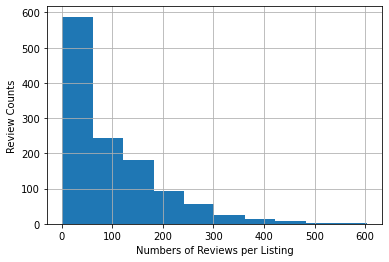

In [13]:
histo = chunk1_reviews_df.listing_id.value_counts().hist()
x= histo.set_xlabel("Numbers of Reviews per Listing")
y = histo.set_ylabel("Review Counts")

The majority of reviews have between 0-75 reviews, with very few listings with greater than 300 reviews. 

The max number of null reviews per listing is 3. While that is significant for some listings, there is no way to recover the data. Therefore, all rows with missing comments will be dropped. 

In [14]:
chunk1_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116838 entries, 0 to 116837
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             116838 non-null  int64 
 1   listing_id     116838 non-null  int64 
 2   date           116838 non-null  object
 3   reviewer_id    116838 non-null  int64 
 4   reviewer_name  116838 non-null  object
 5   comments       116778 non-null  object
dtypes: int64(3), object(3)
memory usage: 5.3+ MB


In [15]:
chunk1_reviews_df.dropna(inplace=True) # drops rows with any NaNs

In [16]:
chunk1_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116778 entries, 0 to 116837
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             116778 non-null  int64 
 1   listing_id     116778 non-null  int64 
 2   date           116778 non-null  object
 3   reviewer_id    116778 non-null  int64 
 4   reviewer_name  116778 non-null  object
 5   comments       116778 non-null  object
dtypes: int64(3), object(3)
memory usage: 6.2+ MB


No other missing data, 116778 reviews remain

In [17]:
chunk1_reviews_df

,id,listing_id,date,reviewer_id,reviewer_name,comments
0,25218143,2384,1/9/2015,14385014,Ivan,it's a wonderful trip experience. I didn't exc...
1,28475392,2384,3/24/2015,16241178,Namhaitou,This is my first trip using Airbnb. I was a li...
2,30273263,2384,4/19/2015,26101401,Patrick,The reservation was canceled 80 days before ar...
3,30974202,2384,4/30/2015,26247321,Cristina,Sólo puedo decir cosas buenas de Rebecca. La h...
4,31363208,2384,5/4/2015,31293837,SuJung,Rebecca was an absolutely wonderful host.\r\n\...
...,...,...,...,...,...,...
116833,179042731,12159695,8/6/2017,14065150,Bel,"Great host, clean apartment, and great locatio..."
116834,195267223,12159695,9/18/2017,148707949,Joshua,Great place! Super chill neighborhood. Check o...
116835,333696318,12159695,10/7/2018,2980548,Christina,"The house is just a block from the Blue line, ..."
116836,448733096,12159695,5/5/2019,58521213,Adrian,Good place! Good value!


In [18]:
# set up dictionary to hold sentence tokens that pertain to each part of review
def def_value(): 
    return []
      
# Defining the dict 
listing_comments = defaultdict(def_value) 

In [19]:
np.set_printoptions(suppress=True) # suppress scientific notation from np
unique_listingIds = np.unique(chunk1_reviews_df.listing_id.values)

The 116778 reviews are for 1211 unique listings

In [20]:
len(unique_listingIds)

1211

In [21]:
for listingId in unique_listingIds: # create default dicts for all the listing ids
    listing_comments[listingId] = defaultdict(def_value)

This section creates sections to divide each review into the categories by which the reviews are grouped. There are six review categories: accuracy, check in, communication, location, value, and cleanliness with a 1 -10 scale. There is an overall review category that is on a 100 point scale.

In [22]:
accuracy_words=["accuracy", "truth", "inaccurate", "correct", "reality", "untrue", "describe", "described","looks",\
                "pictures","pictured","description","photos","advertised"]
checkin_words= ["check in", "met us", "keys","check-in"]
communication_words=["communication","contact","response","answer","reply","communicate","messages", "message","responsive",\
                    "helpful","respond","communicating","communicates","service"]
location_words=["location","site","locale","locality","close","far","spot","bars","train","restaurants","shopping",\
                "dining","safe","dangerous","distance", "proximity", "across","walk","metro","located",\
                "best places of chicago","neighborhood","downtown","brown line","pink line","el station","blue line",\
                "red line","purple line"]
value_words=["value","expensive","cheap","price","budget","fortune","rate", "very near","pricing"]
cleanliness_words = ["clean","dirty","fresh","filty","spotless","immaculate", "cleanliness","tidy","cockroach","sparkling"]


This section does a bit of preprocessing by lowercasing all the text. It then groups the listings into the 6 categories. If the text doesn't fall into these categories, it is grouped into the 'unspecified' category. If a review is in a foreign language, it will also be grouped in that category to be translated and sorted into its correct category at a later point. The foreign language processing is very slow due to rate limits on the server on which the processing happens, so I chose not to do it on the entire set, only text that couldn't immediately be categorized.

In [23]:
for index, row in chunk1_reviews_df.iterrows():
    sentences = sent_tokenize(chunk1_reviews_df['comments'][index])
    for sentence in sentences:
        sentence = sentence.lower()  # lowercase all text
           
        if any(word in sentence for word in accuracy_words):            
            listing_comments[chunk1_reviews_df["listing_id"][index]]['accuracy'].append(sentence)
                
        elif any(word in sentence for word in checkin_words):
            listing_comments[chunk1_reviews_df["listing_id"][index]]['checkin'].append(sentence)
                
        elif any(word in sentence for word in cleanliness_words):
            listing_comments[chunk1_reviews_df["listing_id"][index]]['cleanliness'].append(sentence)
            
        elif any(word in sentence for word in communication_words):
            listing_comments[chunk1_reviews_df["listing_id"][index]]['communication'].append(sentence)
                
        elif any(word in sentence for word in value_words):
            listing_comments[chunk1_reviews_df["listing_id"][index]]['value'].append(sentence)
            
        elif any(word in sentence for word in location_words):
            listing_comments[chunk1_reviews_df["listing_id"][index]]['location'].append(sentence)                    
                                      
        else:
            listing_comments[chunk1_reviews_df["listing_id"][index]]['unspecified'].append(sentence)


In [24]:
len(listing_comments) # all sentences in listing reviews have been sorted by review category

1211

Lemmatization requires a part of speech to work correctly, otherwise all words are assumed to be nouns. When the words are tokenized, it gets tagged with a part of speech by the context. However, that part of speech is more complex than we need for our current purposes. This maps from the complex speech parts to the simpler NOUN = 'n', ADJ = 's', VERB = 'v' and ADV = 'r' that is required for the nltk lemmatizer function.

In [25]:
# Create a map between Treebank and WordNet 
# WordNet POS tags are: NOUN = 'n', ADJ = 's', VERB = 'v', ADV = 'r', ADJ_SAT = 'a'
# Descriptions (c) https://web.stanford.edu/~jurafsky/slp3/10.pdf
tag_map = {
        'CC':None, # coordin. conjunction (and, but, or)  
        'CD':wn.NOUN, # cardinal number (one, two)             
        'DT':None, # determiner (a, the)                    
        'EX':wn.ADV, # existential ‘there’ (there)           
        'FW':None, # foreign word (mea culpa)             
        'IN':wn.ADV, # preposition/sub-conj (of, in, by)   
        'JJ':wn.ADJ, # adjective (yellow)      
        'JJR':wn.ADJ, # adj., comparative (bigger)          
        'JJS':wn.ADJ, # adj., superlative (wildest)           
        'LS':None, # list item marker (1, 2, One)          
        'MD':None, # modal (can, should)                    
        'NN':wn.NOUN, # noun, sing. or mass (llama)          
        'NNS':wn.NOUN, # noun, plural (llamas)                  
        'NNP':wn.NOUN, # proper noun, sing. (IBM)              
        'NNPS':wn.NOUN, # proper noun, plural (Carolinas)
        'PDT':wn.ADJ, # predeterminer (all, both)            
        'POS':None, # possessive ending (’s )               
        'PRP':None, # personal pronoun (I, you, he)     
        'PRP$':None, # possessive pronoun (your, one’s)    
        'RB':wn.ADV, # adverb (quickly, never)            
        'RBR':wn.ADV, # adverb, comparative (faster)        
        'RBS':wn.ADV, # adverb, superlative (fastest)     
        'RP':wn.ADJ, # particle (up, off)
        'SYM':None, # symbol (+,%, &)
        'TO':None, # “to” (to)
        'UH':None, # interjection (ah, oops)
        'VB':wn.VERB, # verb base form (eat)
        'VBD':wn.VERB, # verb past tense (ate)
        'VBG':wn.VERB, # verb gerund (eating)
        'VBN':wn.VERB, # verb past participle (eaten)
        'VBP':wn.VERB, # verb non-3sg pres (eat)
        'VBZ':wn.VERB, # verb 3sg pres (eats)
        'WDT':None, # wh-determiner (which, that)
        'WP':None, # wh-pronoun (what, who)
        'WP$':None, # possessive (wh- whose)
        'WRB':None, # wh-adverb (how, where)
        '$':None, #  dollar sign ($)
        '#':None, # pound sign (#)
        '“':None, # left quote (‘ or “)
        '”':None, # right quote (’ or ”)
        '(':None, # left parenthesis ([, (, {, <)
        ')':None, # right parenthesis (], ), }, >)
        ',':None, # comma (,)
        '.':None, # sentence-final punc (. ! ?)
        ':':None # mid-sentence punc (: ; ... – -)
    }

https://www.analyticsvidhya.com/blog/2018/02/natural-language-processing-for-beginners-using-textblob/ Polarity is float which lies in the range of [-1,1] where 1 means positive statement and -1 means a negative statement. Subjective sentences generally refer to personal opinion, emotion or judgment whereas objective refers to factual information. Subjectivity is also a float which lies in the range of [0,1].

Subjectivity was increased by 1.5 for positive reviews and decreased by 0.5 for negative reviews. The logic behind this was that if a person feels strongly about a place they will use more adjectives, which are words that score higher in the subjectivity score. Based on initial results, it appeared that people's ratings were higher than then their sentiment analysis registered. This may be that people are reluctant to give poor scores despite their experience, or that it is difficult to capture the extent to which a person/group enjoyed a place based on their sentiment. The +1.5  and -0.5 were adjusted to help the results fit the reviews in my training set. The real trial of this will be if it continues to fit in the test set.

In [26]:
def score_calculator(subjectivityscore):
    if subjectivityscore[0]>=0: # if polarity is positive, shift subjectivity score and increase overall score by that amt
        return((subjectivityscore[0]/2*10+5)+(subjectivityscore[1]+1.5)) # shift polarity scale from -1 to 1 to 1 to 10
    else: # if polarity is negative, shift subjectivity score and increase overall score by that amt
        return((subjectivityscore[0]/2*10+5)+(subjectivityscore[1]-0.5))

This is a function to normalize each set of words. It performs spell correction, removes punctuation, creates tokens out of each word, and then finally lemmatizes each word. 

In [27]:
def process_listing_text(listing_dict):
    processed_listing=[]
    for sentence in listing_dict:
        sentence = str(TextBlob(sentence).correct()) # use TextBlob spelling correction
        sentence = re.sub('[^a-zA-Z\s\'\`]', "", sentence) # remove punctuation from sentences        
            
        tokens = word_tokenize(sentence) # Generate list of tokens
        tokens_pos = pos_tag(tokens) 
        tok = ""
        for token in tokens_pos:
            if token != "''" and token[1] != "''" and token[1] != '``':
                if tag_map[token[1]] == wn.NOUN or tag_map[token[1]] == None:
                    tok = 'n'
                elif tag_map[token[1]] == wn.VERB:
                    tok = 'v'
                elif tag_map[token[1]] == wn.ADJ:
                    tok = 's'
                elif tag_map[token[1]] == wn.ADV:
                    tok = 'r'
                processed_listing.append(lemmatizer.lemmatize(token[0],tok))
            processed_listing.append(token[0])
    return(processed_listing)

Stop words 

In [28]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english')) 

In [29]:
for ids in unique_listingIds:
    for sentence in listing_comments[ids]['unspecified']:
        #if len(sentence) > 2:   # must have 3+ characters in string for lang detect
            #blob = TextBlob(sentence) 
            #if blob.detect_language() != 'en': # translate to english
            #    try:
            #        sentence = blob.translate(to= 'en')                    
            #    except:
            #        print(sentence + " not translated")
            #        continue # skip to next sentence
            #time.sleep(5)  # avoid rate limit in TextBlob             
            
        # many words from different languages ended up in the unspecified dict; after translation, re-sort
        if any(word in sentence for word in accuracy_words):            
            listing_comments[chunk1_reviews_df["listing_id"][index]]['accuracy'].append(sentence)
        elif any(word in sentence for word in checkin_words):
            listing_comments[chunk1_reviews_df["listing_id"][index]]['checkin'].append(sentence)
        elif any(word in sentence for word in cleanliness_words):
            listing_comments[chunk1_reviews_df["listing_id"][index]]['cleanliness'].append(sentence)
        elif any(word in sentence for word in communication_words):
            listing_comments[chunk1_reviews_df["listing_id"][index]]['communication'].append(sentence)
        elif any(word in sentence for word in value_words):
            listing_comments[chunk1_reviews_df["listing_id"][index]]['value'].append(sentence)
        elif any(word in sentence for word in location_words):
            listing_comments[chunk1_reviews_df["listing_id"][index]]['location'].append(sentence)                    

In [ ]:
unspecified_wordbag_bylisting = defaultdict(def_value) 
for ids in unique_listingIds:
    unspecified_wordbag_bylisting[ids] = process_listing_text(listing_comments[ids]['unspecified'])

In [ ]:
len(unspecified_wordbag_bylisting)

In [ ]:
unspecified_wordbag_bylisting

In [ ]:
filtered_unspecified_bylisting = defaultdict(def_value)
ss_unspec_bylisting=defaultdict(def_value)
unspecified_score=defaultdict(def_value)
                             
for id in unspecified_wordbag_bylisting:
    filtered_unspecified_bylisting[id] = [w for w in unspecified_wordbag_bylisting[id] if not w in stop_words]       

for ind in filtered_unspecified_bylisting: # get the sentiment on all words in the list per listing id
    ss_unspec_bylisting[ind] = TextBlob(" ".join(filtered_unspecified_bylisting[ind])).sentiment 

for ind in ss_unspec_bylisting:
    unspecified_score[ind] = score_calculator(ss_unspec_bylisting[ind])

In [ ]:
unspecified_score

In [ ]:
accuracy_wordbag_bylisting = defaultdict(def_value) 
for ids in unique_listingIds:
    accuracy_wordbag_bylisting[ids] = process_listing_text(listing_comments[ids]['accuracy'])  
    print(ids, accuracy_wordbag_bylisting[ids])

In [ ]:
len(accuracy_wordbag_bylisting)

In [ ]:
 filtered_accuracy_bylisting = defaultdict(def_value)

In [ ]:
for id in accuracy_wordbag_bylisting:
    filtered_accuracy_bylisting[id] = [w for w in accuracy_wordbag_bylisting[id] if not w in stop_words]  

In [ ]:
len(filtered_accuracy_bylisting)

In [ ]:
filtered_accuracy_bylisting

In [ ]:
for ind in filtered_accuracy_bylisting:
    fd = FreqDist(filtered_accuracy_bylisting[ind])
    #fd.pprint()

In [ ]:
ss_acc_bylisting=defaultdict(def_value)
accuracy_score=defaultdict(def_value)

In [ ]:
for ind in filtered_accuracy_bylisting: # get the sentiment on all words in the list per listing id
    ss_acc_bylisting[ind] = TextBlob(" ".join(filtered_accuracy_bylisting[ind])).sentiment 

In [ ]:
for ind in ss_acc_bylisting:
    accuracy_score[ind] = score_calculator(ss_acc_bylisting[ind])

In [ ]:
accuracy_score

In [ ]:
checkin_bylisting = defaultdict(def_value)  
filtered_checkin_bylisting = defaultdict(def_value)  
ss_checkin_bylisting=defaultdict(def_value)
checkin_score=defaultdict(def_value)

In [ ]:
for ids in unique_listingIds:
    checkin_bylisting[ids] = process_listing_text(listing_comments[ids]['checkin'])                                                                                                                 

In [ ]:
for ids in checkin_bylisting:
    filtered_checkin_bylisting[ids] = [w for w in checkin_bylisting[ids] if not w in stop_words]       

In [ ]:
for ind in filtered_checkin_bylisting: # get the sentiment on all words in the list per listing id
    ss_checkin_bylisting[ind] = TextBlob(" ".join(filtered_checkin_bylisting[ind])).sentiment 

In [ ]:
listing_comments[ids]['checkin']

In [ ]:
for ind in ss_checkin_bylisting:
    checkin_score[ind] = score_calculator(ss_checkin_bylisting[ind])

checkin_score         

In [ ]:
cleanliness_bylisting = defaultdict(def_value)  
filtered_cleanliness_bylisting = defaultdict(def_value)  
ss_clean_bylisting=defaultdict(def_value)
cleanliness_score=defaultdict(def_value)

In [ ]:
#listing_comments['listing_id']['index']['cleanliness']
for ids in unique_listingIds:
    cleanliness_bylisting[ids] = process_listing_text(listing_comments[ids]['cleanliness'])               

In [ ]:
for id in unspecified_wordbag_bylisting:
    filtered_cleanliness_bylisting[id] = [w for w in cleanliness_bylisting[id] if not w in stop_words]       

for ind in filtered_cleanliness_bylisting: # get the sentiment on all words in the list per listing id
    ss_clean_bylisting[ind] = TextBlob(" ".join(filtered_cleanliness_bylisting[ind])).sentiment 

for ind in ss_clean_bylisting:
    cleanliness_score[ind] = score_calculator(ss_clean_bylisting[ind])

cleanliness_score   

In [ ]:
comm_bylisting = defaultdict(def_value)  
filtered_comm_bylisting = defaultdict(def_value)  
ss_comm_bylisting=defaultdict(def_value)
comm_score=defaultdict(def_value)

In [ ]:
#listing_comments['listing_id']['index']['communication']
for ids in unique_listingIds:
    comm_bylisting[ids] = process_listing_text(listing_comments[ids]['communication'])               

In [ ]:
for id in unspecified_wordbag_bylisting:
    filtered_comm_bylisting[id] = [w for w in comm_bylisting[id] if not w in stop_words]       

for ind in filtered_unspecified_bylisting: # get the sentiment on all words in the list per listing id
    ss_comm_bylisting[ind] = TextBlob(" ".join(filtered_comm_bylisting[ind])).sentiment 

for ind in ss_unspec_bylisting:
    comm_score[ind] = score_calculator(ss_comm_bylisting[ind])

comm_score

In [ ]:
value_bylisting = defaultdict(def_value)  
filtered_value_bylisting = defaultdict(def_value)  
ss_value_bylisting=defaultdict(def_value)
value_score=defaultdict(def_value)

In [ ]:
#listing_comments['listing_id']['index']['value']
for ids in unique_listingIds:
    value_bylisting[ids] = process_listing_text(listing_comments[ids]['value'])               

In [ ]:
for id in value_bylisting:
    filtered_value_bylisting[id] = [w for w in value_bylisting[id] if not w in stop_words]       

for ind in filtered_value_bylisting: # get the sentiment on all words in the list per listing id
    ss_value_bylisting[ind] = TextBlob(" ".join(filtered_value_bylisting[ind])).sentiment 

for ind in ss_unspec_bylisting:
    value_score[ind] = score_calculator(ss_value_bylisting[ind])

value_score

In [ ]:
location_bylisting = defaultdict(def_value)  
filtered_location_bylisting = defaultdict(def_value)  
ss_loc_bylisting=defaultdict(def_value)
location_score=defaultdict(def_value)

In [ ]:
#listing_comments['listing_id']['index']['location']
for ids in unique_listingIds:
    location_bylisting[ids] = process_listing_text(listing_comments[ids]['location'])    

In [ ]:
for id in location_bylisting:
    filtered_location_bylisting[id] = [w for w in location_bylisting[id] if not w in stop_words]       

for ind in filtered_unspecified_bylisting: # get the sentiment on all words in the list per listing id
    ss_loc_bylisting[ind] = TextBlob(" ".join(filtered_location_bylisting[ind])).sentiment 

for ind in ss_unspec_bylisting:
    location_score[ind] = score_calculator(ss_loc_bylisting[ind])

location_score

In [ ]:
dat = {'AccuracyScore_calc': accuracy_score, 'CleanScore_calc':cleanliness_score, 'CheckinScore_calc':checkin_score, 'CommScore_calc':comm_score, 'LocationScore_calc':location_score, 'ValueScore_Calc':value_score}
review_scores_df = pd.DataFrame(data=dat)

In [ ]:
review_scores_df.to_csv('review_scores.csv')